# Let's put it together

In [1]:
#%%writefile train_model.py
"""train_model.py

I'm testing if I can sensibly condense a jupyter notebook into a script via %%writefile cell magic.
"""
# Load parent folders into path
import sys
import os
import inspect
import pathlib
import shutil

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
# Import some config variables
from config import PETER_ROOT, DATA_DIR, MNIST_SIZE


# Plotting
from plot_mnist import plot_batch, plot_digit

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import crypten
import crypten.communicator as mpc_comm # the communicator is similar to the MPI communicator for example
from crypten import mpc

assert sys.version_info[0] == 3 and sys.version_info[1] == 7, "python 3.7 is required!"

print(f"Okay, good! You have: {sys.version_info[:3]}")
# Now we can init crypten!
crypten.init()

Okay, good! You have: (3, 7, 9)


In [2]:
%%writefile lib/dir_setup.py
"""dir_setup.py

Functions for data directory setup and generation of filename dictionary.
"""
import pathlib
import shutil

def rm_files_in_dir(directoy:pathlib.Path, recursive=False):
    if not directory.exists():
        print(f"{directory} does not exist")
    else:
        if recursive:
            # Simple non-recursive glob --> doesn't look into subdirectories
            for file in [x for x in directory.glob("*") if x.is_file()]:
                file.unlink()
            print(f"{directory} cleaned!")
        else:
            # Use recursive glob
            for file in [x for x in directory.rglob("*") if x.is_file()]:
                file.unlink()
            print(f"{directory} and it's subdirectories cleaned!")

def check_and_mkdir(directory:pathlib.Path):
    if not directory.exists():
        print(f"Directory {directory} created.")
        directory.mkdir()

def rm_dir(directory:pathlib.Path):
    shutil.rmtree(directory)
    
def get_filenames(directory:pathlib.Path, participants):
    # Specify file locations to save each piece of data
    filenames = {
        "features": directory / "features.pth",
        "labels": directory / "labels.pth",
        "b_true": directory / "b_true.pth",
        "test_features": directory / "test_features.pth",
        "targets": directory / "targets.pth",
        "w_true": directory / "w_true.pth",
    }

    rank = 0
    for u in participants:
        filenames["labels_"+u] = (directory / (f"labels_{u}.pth"), rank)
        filenames["features_"+u] = (directory / (f"features_{u}.pth"), rank)
        rank += 1
    return filenames

def setup(participants, tmp_dir_name="./TMP"):
    num_participants = len(participants)
    TMP_DIR = pathlib.Path(tmp_dir_name)
    print(f"Our temporary data will land here: {TMP_DIR}")
    check_and_mkdir(TMP_DIR)
    filenames = get_filenames(TMP_DIR, participants)
    return TMP_DIR, filenames, num_participants 

POSSIBLE_PARTICIPANTS = ("alice, bob, clara, daniel, " + 
    "elina, franz, georg, hilda, ilya, julia, karin, luke, " +
    "martin, nadia, olaf, peter, queenie, rasmus, sarah, tal, " +
    "ulyana, valerie, walter, xander, ymir, zorro").split(", ")

Overwriting lib/dir_setup.py


In [3]:
from lib.dir_setup import *

len(POSSIBLE_PARTICIPANTS)
# Across
participants = POSSIBLE_PARTICIPANTS[:2]
dir_name = "./TMP_" + "train_on_shared_data"

TMP_DIR, filenames, num_participants = setup(participants, tmp_dir_name=dir_name)
DATA_DIR = TMP_DIR / "data"
participants

Our temporary data will land here: TMP_train_on_shared_data


['alice', 'bob']

In [4]:
print(participants)
print(TMP_DIR)
print(filenames)

['alice', 'bob']
TMP_train_on_shared_data
{'features': PosixPath('TMP_train_on_shared_data/features.pth'), 'labels': PosixPath('TMP_train_on_shared_data/labels.pth'), 'b_true': PosixPath('TMP_train_on_shared_data/b_true.pth'), 'test_features': PosixPath('TMP_train_on_shared_data/test_features.pth'), 'targets': PosixPath('TMP_train_on_shared_data/targets.pth'), 'w_true': PosixPath('TMP_train_on_shared_data/w_true.pth'), 'labels_alice': (PosixPath('TMP_train_on_shared_data/labels_alice.pth'), 0), 'features_alice': (PosixPath('TMP_train_on_shared_data/features_alice.pth'), 0), 'labels_bob': (PosixPath('TMP_train_on_shared_data/labels_bob.pth'), 1), 'features_bob': (PosixPath('TMP_train_on_shared_data/features_bob.pth'), 1)}


## Binary (black/white) images

https://madflex.de/mnist-with-binary-color/

In [5]:
# MNIST has 60000 images for train
#           10000 images for test
subset = 1/60
train_ratio = 0.75
test_ratio = 1 - train_ratio
batch_size_train = int((subset * MNIST_SIZE) * train_ratio)
batch_size_test = int((subset * MNIST_SIZE) * test_ratio)

print(f"Using train_test ratios: {train_ratio} : {test_ratio}")
print(f"Train batch size: {batch_size_train}")
print(f"Test batch size: {batch_size_test}")

black_white_transform = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                lambda x: x>0,
                                lambda x: x.float(),
                             ])

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(DATA_DIR, train=True, download=True,
                             transform=black_white_transform),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(DATA_DIR, train=False, download=True,
                             transform=black_white_transform),
  batch_size=batch_size_test, shuffle=True)

train_batches = enumerate(train_loader)
test_batches = enumerate(test_loader)

Using train_test ratios: 0.75 : 0.25
Train batch size: 750
Test batch size: 250


In [6]:
train_idx, digits = next(train_batches)
test_idx, digits_test = next(test_batches)

#check if tensor shapes match the desired sizes
print(f"train set: {digits[0].shape} [", end="")
if digits[0].shape[0] == batch_size_train:
    print("CHECK]")
else:
    print("FAILURE]")
    
print(f"test set: {digits_test[0].shape} [", end="")
if digits_test[0].shape[0] == batch_size_test:
    print("CHECK]")
else:
    print("FAILURE]")

train set: torch.Size([750, 1, 28, 28]) [CHECK]
test set: torch.Size([250, 1, 28, 28]) [CHECK]


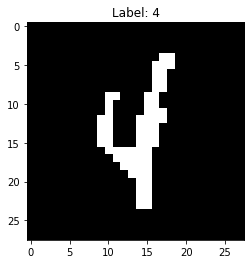

In [7]:
img_num = 3
plot_digit(digits[0][img_num], digits[1][img_num]) # plt.imshow(image, cmap='gray')

# Save encrypted data for each participant

In [8]:
%%writefile lib/data.py
"""data.py
Helper functions for splitting the dataset
"""
import numpy as np

def get_indices(length, num_splits):
    step = int(length / num_splits)
    return np.arange(0, length+1, step=step, dtype=int)
    
def split_data(data, frac):
    length = len(data[1]) #.shape[0]
    split_idx = int(length*frac)
    print(f"Returning: 0 <-1-> {split_idx} <-2->{length}")
    feats_1, labels_1 = data[0][:split_idx], data[1][:split_idx]
    feats_2, labels_2 = data[0][split_idx:], data[1][split_idx:]
    return (feats_1, labels_1), (feats_2, labels_2)

def split_data_even(data, num_splits:int):
    length = len(data[1]) #.shape[0]
    split_idx = get_indices(length, num_splits)
    return [[data[0][start:stop], data[1][start:stop]] for (start, stop) in zip(split_idx[:-1], split_idx[1:])]

if __name__=="__main__":
    pass

Overwriting lib/data.py


In [9]:
%%writefile lib/mpc_helpers.py
"""mpc_helpers.py
Helper functions for MPC execution
"""

def mpc_check(func):
    """Gathers the return values and evaluates for execution success.
    """
    def wrapper(*args, **kwargs):
        process_results = func(*args, **kwargs)
        if not all(process_results):
            print("SUCCESS")
        else:
            print("FAILURE")
    return wrapper

Overwriting lib/mpc_helpers.py


In [10]:
%%writefile lib/mpc_tests.py
"""mpc_tests.py
Some test functions I wrote to test MPC execution."""
import torch
import crypten
import crypten.communicator as mpc_comm # the communicator is similar to the MPI communicator for example
from crypten import mpc
from .mpc_helpers import *

world_size = 5
        
@mpc_check
@mpc.run_multiprocess(world_size=world_size)
def test():
    ws = mpc_comm.get().world_size
    rank = mpc_comm.get().get_rank()
    print(rank)
    tens = torch.tensor([x for x in range(ws+1)])
    #for rank in range(ws):
    crypten.save(tens, f"test_{rank}.pth", src=rank)
        #crypten.save_from_party(tens, f"test_{rank}", src=rank)

@mpc_check
@mpc.run_multiprocess(world_size=world_size)
def test_load():
    ws = mpc_comm.get().world_size
    rank = mpc_comm.get().get_rank()
    print(rank)
    data = []
    for rank in range(ws):
        data.append(crypten.load(f"test_{rank}.pth", src=rank))
    print(data[0])
    print(data[0].get_plain_text())
        
def test_solo(world_size=world_size):
    tens = torch.tensor([x for x in range(world_size+1)])
    for rank in range(world_size):
        crypten.save(tens, f"test_{rank}.pth", src=rank)

if __name__=="__main__":
    test()
    test_load()
    #test_solo()   

Overwriting lib/mpc_tests.py


In [11]:
from lib.mpc_tests import *

test_load()

10

43

2
MPCTensor(
	_tensor=tensor([-2172557661602100065, -8248486143624092936, -4558660403164687987,
         7039022768983006833, -8313906410089631684, -4268521608253602023])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)MPCTensor(
	_tensor=tensor([ 7912642241335785473, -3620438739574442985,  3367502635828789862,
         3278714478180808805, -7511149405755644855, -5686072549534639814])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)MPCTensor(
	_tensor=tensor([ 6242375538590409053,  3427794405493272190, -4625541581625966160,
        -4726869530904739858, -7372530666278649040,  1462026523063818876])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)MPCTensor(
	_tensor=tensor([ 3969357485734658394,  2144106168105361921,  9132555315178058488,
         -230083729833152257, -3947910481791341975,  4311825568165893937])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)MPCTensor(
	_tensor=tensor([ 2494926469650798761,  6297024309599967346, -3315855966216063131,
        -5360783986425726915,  8698752890205

In [12]:
from lib.data import *
from lib.mpc_helpers import *

# Split data and save
data_batches = split_data_even(digits, num_participants)

# Save features, labels for Data Labeling example
# All plain text essentially
crypten.save(digits[0], filenames["features"])
crypten.save(digits[1], filenames["labels"])
crypten.save(digits_test[0], filenames["test_features"])
crypten.save(digits_test[1], filenames["targets"])
    
@mpc_check
@mpc.run_multiprocess(world_size=num_participants)
def save_all_data():
    my_rank = mpc_comm.get().get_rank()
    world_size = mpc_comm.get().world_size
    #print(f"Hello from {my_rank}")
    
    image_batch = data_batches[my_rank][0]
    label_batch = data_batches[my_rank][1]
    name = participants[my_rank]
    
    crypten.save(image_batch, filenames[f"features_{name}"][0], src=my_rank)
    crypten.save(label_batch, filenames[f"labels_{name}"][0], src=my_rank)
    
    #print(f"{my_rank} is done! Signing off...")
    
save_all_data()

SUCCESS


# Setup the training loop

## About the mpc.run_multiprocess decorator

To execute multi-party computations locally, we provide a `@mpc.run_multiprocess` function decorator, which we developed to execute CrypTen code from a single script. CrypTen follows the standard MPI programming model: it runs a separate process for each party, but each process runs an identical (complete) program. Each process has a rank variable to identify itself.

[Docs](https://crypten.readthedocs.io/en/latest/mpctensor.html#communicator)

In [13]:
%%writefile lib/jupyter_helpers.py
"""jupyter_helpers.py

"""
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

def stop_cell():
    print(("Stopping cell execution"))
    raise StopExecution
    print("This shouldn't appear...")

Overwriting lib/jupyter_helpers.py


In [14]:
feature_keys = [x for x in filenames.keys() if "features_" in x]
label_keys = [x for x in filenames.keys() if "labels_" in x]
feature_files = [filenames[x] for x in feature_keys]
label_files = [filenames[x] for x in label_keys]

Xs = [crypten.load(file, src=0) for file, rank in feature_files]
for x in Xs:
    print(x.shape)
# Combine the feature sets: identical to Tutorial 3
X = crypten.cat(Xs, dim=0)
X.shape

torch.Size([375, 1, 28, 28])
torch.Size([375, 1, 28, 28])


torch.Size([750, 1, 28, 28])

In [44]:
Ys = [crypten.load(file, src=0) for file, enc_rank in label_files]
y = crypten.cat(Ys, dim=0)
print(y.shape)
pt_y = y.get_plain_text()

y_one_hot = torch.nn.functional.one_hot(pt_y.long(), 10)
y_one_hot[:3]


torch.Size([750])


tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

In [ ]:
from lib.jupyter_helpers import *
# Load a pytorch net
from ZeNet.nets import *
from time import time
TrainNet = Net1 # Don't instantiate yet

#stop_cell()
# filenames has to be defined
feature_keys = [x for x in filenames.keys() if "features_" in x]
label_keys = [x for x in filenames.keys() if "labels_" in x]
feature_files = [filenames[x] for x in feature_keys]
label_files = [filenames[x] for x in label_keys]

# Convert labels to one-hot encoding
# Since labels are public in this use case, we will simply use them from loaded torch tensors
#labels = torch.load('/tmp/train_labels.pth')
#labels = labels.long()
#labels_one_hot = label_eye[labels]

#@mpc_check
@mpc.run_multiprocess(world_size=num_participants)
def run_encrypted_training():
    rank = mpc_comm.get().get_rank()
    # Load data:
    #x_alice_enc = crypten.load('/tmp/alice_train.pth', src=ALICE)
    #x_bob_enc = crypten.load('/tmp/bob_train.pth', src=BOB)

    if rank == 0:
        print(f"Process {rank} says hello!")
        print(f"Loading data now...")
    Xs = [crypten.load(file, src=enc_rank) for file, enc_rank in feature_files]
    Ys = [crypten.load(file, src=enc_rank) for file, enc_rank in label_files]
    
    X = crypten.cat(Xs, dim=0)
    y = crypten.cat(Ys, dim=0)
    del Ys 
    del Xs
    y_one_hot = crypten.cryptensor(torch.nn.functional.one_hot(y.get_plain_text().long(), 10))
    if rank == 0:
        print(f"X: {type(X)}")
        print(f"Y: {type(y)}")
        
    if rank == 0:
        print("Loading model now...")
    # Initialize a plaintext model and convert to CrypTen model
    #dummy_input = X[0]
    dummy_input = torch.empty(1, 1, 28, 28)
    model = crypten.nn.from_pytorch(TrainNet(), dummy_input)
    model.encrypt()
    
    # Set train mode
    model.train()
  
    # Define a loss function
    #criterion = crypten.nn.MSELoss()
    criterion = crypten.nn.CrossEntropyLoss()

    if rank == 0:
        print("Setting up training environment and hyperparameters...")
    # Define training parameters
    learning_rate = 0.001
    epochs = 10
    #batch_size = 10
    #num_batches = x_combined_enc.size(0) // batch_size
    
    if rank == 0:
        print(f"Initialization and loading done...starting training now!")
    
    for epoch in range(1, epochs+1):
        if rank == 0:
            print(f"#----- EPOCH #{epoch} -----#")
            start = time()
        model.zero_grad()
        output = model(X)
        if rank == 0:
            print("Computing loss...")
        
        if output.shape != y_one_hot.shape:
            if rank == 0:
                print("output and labels have unequal shape!")
                print(f"output: {output.shape}")
                print(f"y: {y_one_hot.shape}")
            return -1
        loss = criterion(output, y_one_hot)
        pt_loss = loss.get_plain_text()
        if rank == 0:
            print(f"epoch {epoch} loss: {pt_loss}")
        loss.backward()
        model.update_parameters(learning_rate)
        if rank == 0:
            stop = time()
            print(f"Epoch time: {stop - start}s")
    return 0

print("Starting MPC encrypted training now!")
run_encrypted_training()

Starting MPC encrypted training now!
Process 0 says hello!
Loading data now...
X: <class 'crypten.mpc.mpc.MPCTensor'>
Y: <class 'crypten.mpc.mpc.MPCTensor'>
Loading model now...
Setting up training environment and hyperparameters...
Initialization and loading done...starting training now!
#----- EPOCH #1 -----#
Computing loss...
epoch 1 loss: 2.323333740234375
Epoch time: 141.3054850101471s
#----- EPOCH #2 -----#


In [ ]:
a

In [ ]:
from lib.jupyter_helpers import *
# Load a pytorch net
from ZeNet.nets import *
TrainNet = Net1 # Don't instantiate yet

#stop_cell()
# filenames has to be defined
feature_keys = [x for x in filenames.keys() if "features_" in x]
label_keys = [x for x in filenames.keys() if "labels_" in x]
feature_files = [filenames[x] for x in feature_keys]
label_files = [filenames[x] for x in label_keys]

# Convert labels to one-hot encoding
# Since labels are public in this use case, we will simply use them from loaded torch tensors
#labels = torch.load('/tmp/train_labels.pth')
#labels = labels.long()
#labels_one_hot = label_eye[labels]

@mpc_check
@mpc.run_multiprocess(world_size=num_participants)
def run_encrypted_training():
    rank = mpc_comm.get().get_rank()
    # Load data:
    #x_alice_enc = crypten.load('/tmp/alice_train.pth', src=ALICE)
    #x_bob_enc = crypten.load('/tmp/bob_train.pth', src=BOB)

    if rank == 0:
        print(f"Process {rank} says hello!")
        print(f"Loading data now...")
    Xs = [crypten.load(file, src=enc_rank) for file, enc_rank in feature_files]
    X = crypten.cat(Xs, dim=0)
    Ys = [crypten.load(file, src=enc_rank) for file, enc_rank in label_files]
    y = crypten.cat(Ys, dim=0)
    
    
    if rank == 0:
        print("Loading model now...")
    # Initialize a plaintext model and convert to CrypTen model
    #dummy_input = X[0]
    dummy_input = torch.empty(1, 1, 28, 28)
    model = crypten.nn.from_pytorch(TrainNet(), dummy_input)
    #model.encrypt()
    
    # Set train mode
    model.train()
  
    # Define a loss function
    criterion = crypten.nn.MSELoss()
    #criterion = crypten.nn.CrossEntropyLoss()

    if rank == 0:
        print("Setting up training environment and hyperparameters...")
    # Define training parameters
    learning_rate = 0.001
    epochs = 2
    #batch_size = 10
    #num_batches = x_combined_enc.size(0) // batch_size
    
    if rank == 0:
        print(f"Initialization and loading done...starting training now!")
    
    for epoch in range(1, epochs+1):
        if rank == 0:
            print(f"#----- EPOCH #{epoch} -----#")
        model.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        pt_loss = loss.get_plain_text()
        if rank == 0:
            print(f"epoch {epoch} loss: {pt_loss}")
        loss.backward()
        model.update_parameters(learning_rate)

run_encrypted_training()

### Some unused stuff

In [ ]:
# Unused!
def load_enc_data(X_files, y_files):
    # Load images
    X = []
    for file, rank in X_files:
        X.append(crypten.load(file, src=rank))
        
    # Load labels
    y = []
    for file, rank in y_files:
        y.append(crypten.load(file, src=rank))
        
    return X, y

def load_model(Net, dummy_input, ENC_RANK):
    # (1, 1, 28, 28)
    private_model = crypten.nn.from_pytorch(Net, dummy_input)
    private_model.encrypt(src=ENC_RANK)
    return private_model

def train_model(model, X, y, epochs=10, learning_rate=0.05):
    criterion = crypten.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        print(f"epoch {epoch} loss: {loss.get_plain_text()}")
        loss.backward()
        model.update_parameters(learning_rate)
    return model

def evaluate_model():
    pass


In [ ]:
labels = torch.load('/tmp/bob_test_labels.pth').long()
count = 100 # For illustration purposes, we'll use only 100 samples for classification

@mpc.run_multiprocess(world_size=2)
def encrypt_model_and_data():
    # Load pre-trained model to Alice
    model = crypten.load('models/tutorial4_alice_model.pth', dummy_model=dummy_model, src=ALICE)
    
    # Encrypt model from Alice 
    dummy_input = torch.empty((1, 784))
    private_model = crypten.nn.from_pytorch(model, dummy_input)
    private_model.encrypt(src=ALICE)
    
    # Load data to Bob
    data_enc = crypten.load('/tmp/bob_test.pth', src=BOB)
    data_enc2 = data_enc[:count]
    data_flatten = data_enc2.flatten(start_dim=1)

    # Classify the encrypted data
    private_model.eval()
    output_enc = private_model(data_flatten)
    
    # Compute the accuracy
    output = output_enc.get_plain_text()
    accuracy = compute_accuracy(output, labels[:count])
    print("\tAccuracy: {0:.4f}".format(accuracy.item()))
    
encrypt_model_and_data()

## Running on different machines

Tricky: https://github.com/facebookresearch/CrypTen/issues/104

Scripts: <https://github.com/facebookresearch/CrypTen/tree/master/scripts>